# Estimando parâmetros de modelos EDO
Nesta aula, vamos utilizar a biblioteca PyMC3 para fazer a estimação de parâmetros de um modelo SIR
Para executar este notebook vamos precisar instalar o pymc3
```
pip install pymc3
```

In [2]:
%matplotlib inline
import pymc3 as pm
from pymc3.ode import DifferentialEquation
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import arviz as az
import theano

plt.style.use('seaborn-darkgrid')

O primeiro passo é implementar o nosso modelo 

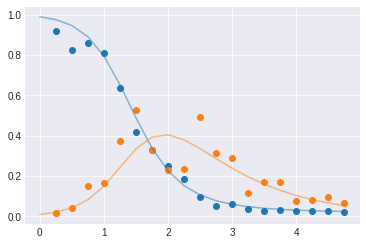

In [6]:
def SIR(y, t, p):
    ds = -p[0] * y[0] * y[1]
    di = p[0] * y[0] * y[1] - p[1] * y[1]
    return [ds, di]

times = np.arange(0, 5, 0.25)

beta,gamma = 4,1.0
# Create true curves
y = odeint(SIR, t=times, y0=[0.99, 0.01], args=((beta, gamma),), rtol=1e-8)
# Observational model.  Lognormal likelihood isn't appropriate, but we'll do it anyway
yobs = np.random.lognormal(mean=np.log(y[1::]), sigma=[0.2, 0.3])

plt.plot(times[1::], yobs, marker='o', linestyle='none')
plt.plot(times, y[:, 0], color='C0', alpha=0.5, label=f'$S(t)$')
plt.plot(times, y[:, 1], color='C1', alpha=0.5, label=f'$I(t)$');
plt.legend();


In [ ]:
sir_model = DifferentialEquation(
    func=SIR,
    times=np.arange(0.25, 5, 0.25),
    n_states=2,
    n_theta=2,
    t0=0,
)

In [ ]:
%%time
with pm.Model() as model4:
    sigma = pm.HalfCauchy('sigma', 1, shape=2)

    # R0 is bounded below by 1 because we see an epidemic has occured
    R0 = pm.Bound(pm.Normal, lower=1)('R0', 2, 3)
    gam = pm.Lognormal('gamma', pm.math.log(2), 2)
    beta = pm.Deterministic('beta', gam * R0)

    sir_curves = sir_model(y0=[0.99, 0.01], theta=[beta, gam])

    Y = pm.Lognormal('Y', mu=pm.math.log(sir_curves), sigma=sigma, observed=yobs)

    trace = pm.sample(2000, tune=1000, target_accept=0.9, cores=8)
    data = az.from_pymc3(trace=trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [gamma, R0, sigma]


In [20]:
data

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [33]:
az.plot_posterior(data, round_to=2, hdi_prob=0.95);

AttributeError: module 'matplotlib.cbook' has no attribute '_rename_parameter'

In [34]:
%load_ext watermark
%watermark -n -u -v -iv -w

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
numpy  1.16.6
pymc3  3.9.3
theano 1.0.5
arviz  0.10.0
last updated: Mon Oct 12 2020 

CPython 3.7.3
IPython 5.8.0
watermark 2.0.2


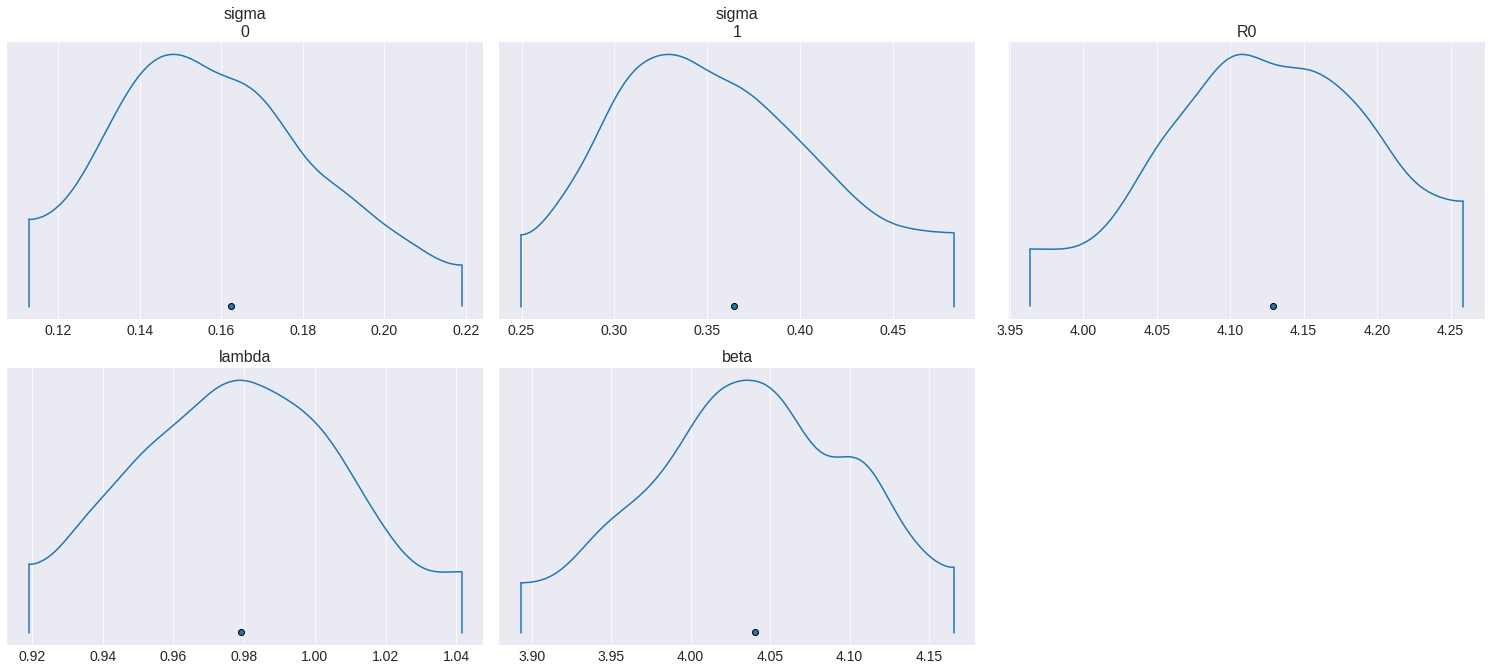

In [37]:
az.plot_density(data);